In [64]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [65]:
class frocc:
  def __init__(self, m, eps, d, seed=None) -> None:
    if (seed != None):
      np.random.seed(seed)
    self.m = m
    self.eps = eps
    self.d = d

    # Generate random vectors from d-dim unit sphere
    # by x/|x|, x ~ N(0,I_d)
    random_vectors = st.multivariate_normal.rvs(np.zeros(d), np.eye(d), m)
    self.random_proj = np.divide(
      random_vectors, 
      np.linalg.norm(random_vectors, axis=1).repeat(d).reshape(m,d)
    )
    self.outlier_intervals = np.array([])
    self.min_values = np.array([])
    self.max_values = np.array([])
    
  def train(self, data):
    N, d_data = data.shape
    if d_data != self.d:
      raise ValueError("Dimensions must match. d = " + str(d) + " != " + str(d_data) + " = d_data.")

    # projection onto unit vector = dot product
    dot_products = self.random_proj @ data.T
    min_values = np.min(dot_products, axis=1)
    max_values = np.max(dot_products, axis=1)

    # Need to min-max normalize and sort projections to
    # create outlier intervals along each projection vector
    scaled_dot_products = np.divide(
      dot_products - min_values.repeat(N).reshape(self.m,N),
      (max_values - min_values).repeat(N).reshape(self.m,N)
    )
    sorted_scaled_dot_products = np.sort(scaled_dot_products, axis=1)

    # Find indices where outlier intervals start
    two_d_interval_indices = np.argwhere(
      np.diff(sorted_scaled_dot_products, axis=1) >= eps
    )
    outlier_break_points = [[ 
      index[1] for index in two_d_interval_indices if index[0] == i 
    ] for i in range(self.m) ]

    self.min_values = min_values
    self.max_values = max_values
    self.outlier_intervals = [[ 
      [
        sorted_scaled_dot_products[i,index],
        sorted_scaled_dot_products[i,index+1]
      ] for index in outlier_break_points[i] 
    ] for i in range(self.m)]

  def test(self, data):
    N, d_data = data.shape
    if d_data != self.d:
      raise ValueError("Dimensions must match. d = " + str(d) + " != " + str(d_data) + " = d_data.")

    # Find projection of testing data and rescale
    # to the same scale as training data
    projection_new_data = self.random_proj @ data.T
    scaled_new_data = np.divide(
      projection_new_data.reshape(self.m,N) -
        self.min_values.repeat(N).reshape(self.m,N),
      (self.max_values - self.min_values).repeat(N).reshape(self.m,N)
    )

    # Outliers are either more extreme than any training data
    # or are within some outlier intervals
    extreme_upper = scaled_new_data > 1
    extreme_lower = scaled_new_data < 0
    inliers = np.logical_not(np.any(np.logical_or(extreme_upper, extreme_lower), axis=0))
    # print(scaled_new_data.shape)
    # print(inliers)

    # Check intervals where there are no extreme values
    for i in range(self.m):
      # Find indices of non-extreme values
      non_extreme_indices = np.argwhere(inliers).flatten()
      to_check = inliers[non_extreme_indices]

      # Retrieve data that must be checked
      data_to_check = scaled_new_data[i, non_extreme_indices]
      for outlier in self.outlier_intervals[i]:
        # For each outlier interval, 
        # update indices with new outliers
        to_check = np.logical_and(
          to_check,
          np.logical_not(
            np.logical_and(
              data_to_check > outlier[0], 
              data_to_check < outlier[1]
            )
          )
        )
      # Update the global record of inliers.
      # When a data point is found to be anomalous,
      # it is no longer checked every iteration.
      inliers[non_extreme_indices] = to_check

    return np.logical_not(inliers)

In [66]:
np.logical_and([True,False],[True,True])

array([ True, False])

In [67]:
# m = number of random projection vectors
# d = data dimension
# N = number of data points
m = 10
d = 1000
N_data = 1000
N_new = 100
eps = 0.1

In [68]:
# Generate some training data
np.random.seed(1000)
data = st.multivariate_normal.rvs(np.zeros(d), np.eye(d), size = N_data)

# And some testing data
new_data = st.multivariate_normal.rvs(np.ones(d) * 3, np.eye(d), size = N_new)

In [69]:
detector = frocc(m, eps, d, seed=64)
# detector.train(data)
# detector.test(new_data).mean()

In [70]:
detector.train(data)

In [71]:
detector.test(new_data).mean()

1.0

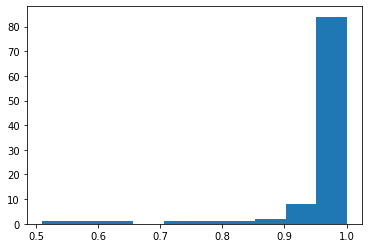

In [72]:
k = 100
accuracies = np.zeros(k)
for i in range(k):
  detector = frocc(m, eps, d, seed=None)
  detector.train(data)
  accuracies[i] = detector.test(new_data).mean()

plt.hist(accuracies);